In [1]:
%pip install mitiq
%pip install pennylane

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Zero-Noise Extrapolation (ZNE) with Pauli tailored noise in Mitiq

This is Part 2 of the Mitiq tutorial at IEEE QCE 2024. In Part 1, we went over the workflow for ZNE with an example. 

In this tutorial, we will:

- Compare the pauli transfer matrices of coherent noise and incoherent noise
- Pauli twirl the coherent noise to be incoherent
- Compare performance of a ZNE circuit subjected to coherent noise before and after Pauli twirling

## Pauli twirling

### Define an ideal circuit with a CNOT gate

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from cirq import LineQubit, Circuit, CNOT, H, S, T, Rx, Ry, Rz, depolarize, amplitude_damp, X, Y, Z
from pt_utils import ptm_matrix

q0 = LineQubit(0)
q1 = LineQubit(1)

circuit = Circuit(CNOT(q0, q1))
circuit

0: ───@───
      │
1: ───X───

### Ideal Pauli Transfer Matrix (PTM)

Ideal CNOT PTM


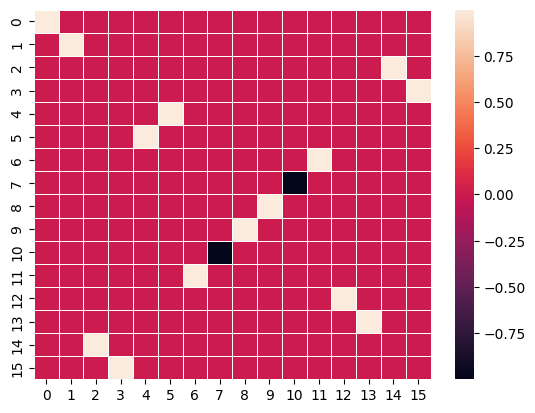

In [3]:
ptmcnot = ptm_matrix(circuit, 2)
ax = sns.heatmap(ptmcnot.real, linewidth=0.5)
print("Ideal CNOT PTM")
plt.show()

### Add noise to the CNOT gate circuit

If you are executing the circuit on a simulator, you have to insert a source of noise in the circuit. As Mitiq's Pauli Twirling module twirls noise on CZ/CNOT gates,
the example we focus on is a noisy CNOT circuit. Some example sources of noise that you can insert in your circuit are shown below. As stated earlier, you cannot insert incoherent noise in your circuit and expect Pauli twirling to alter the circuit noise. 

| Incoherent Noise      | Coherent Noise |
| ----------- | ----------- |
| Depolarizing Channel      | Rotation gates: Rx, Ry, Rz       |
| Amplitude Damping Channel   | H        | 
| .....   | .......       |
|......|.....|

**Exercise:** What other sources of noise could be added to the above table?

- https://quantumai.google/reference/python/cirq/depolarize
- https://quantumai.google/reference/python/cirq/Z
- https://quantumai.google/reference/python/cirq/Rx
- https://quantumai.google/reference/python/cirq/H 

Pauli Transfer Matrix of noisy CNOT (incoherent)


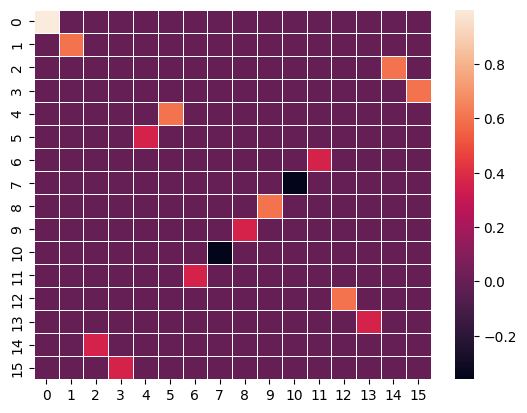

In [4]:
# PTM of a noisy CNOT gate: depolarizing noise
noisy_circuit_incoherent = circuit.with_noise(depolarize(p=0.3))
ptmcnot = ptm_matrix(noisy_circuit_incoherent, 2)
ax = sns.heatmap(ptmcnot.real, linewidth=0.5)
print("Pauli Transfer Matrix of noisy CNOT (incoherent)")
plt.show()

Pauli Transfer Matrix of noisy CNOT (coherent)


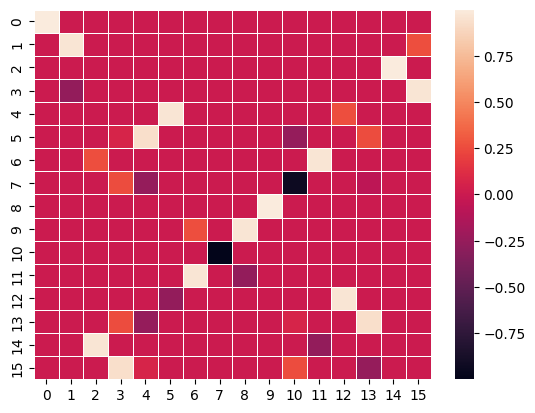

In [5]:
# PTM of a noisy CNOT gate: Ry
noisy_circuit_coherent = circuit.with_noise(Ry(rads=np.pi/12))
ptmcnot = ptm_matrix(noisy_circuit_coherent, 2)
ax = sns.heatmap(ptmcnot.real, linewidth=0.5)
print("Pauli Transfer Matrix of noisy CNOT (coherent)")
plt.show()

⚠️ Note: Tha Pauli twirling utility module is currently under construction 🚧. For large circuits, demonstrating the efficacy of pauli twirling through the pauli transfer matrix becomes inconvenient ⚠️.  

### Pauli Twirling in Mitiq on a simple circuit

In [6]:
from cirq import LineQubit, Circuit, CZ, CNOT, H

q0, q1, q2, q3  = LineQubit.range(4)
circuit = Circuit(
    H(q0),
    CNOT.on(q0, q1),
    CZ.on(q1, q2),
    CNOT.on(q2, q3),
)

print(circuit)

0: ───H───@───────────
          │
1: ───────X───@───────
              │
2: ───────────@───@───
                  │
3: ───────────────X───


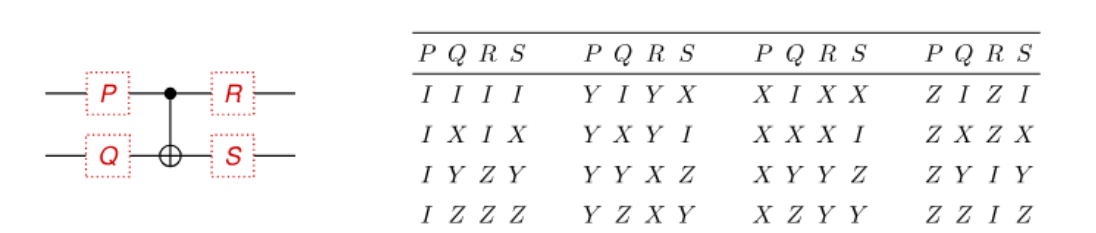

In [7]:
from mitiq.pt import generate_pauli_twirl_variants
# Generate twirled circuits
NUM_TWIRLED_VARIANTS = 30
twirled_circuits = generate_pauli_twirl_variants(circuit, num_circuits=NUM_TWIRLED_VARIANTS)
twirled_circuits[0]

0: ───H───Y───@───X───────────────────────────
              │
1: ───────Y───X───Z───Y───@───Y───────────────
                          │
2: ───────────────────Z───@───I───I───@───Z───
                                      │
3: ───────────────────────────────Z───X───Z───

### Execute the circuit

In [8]:
from numpy import pi
from cirq import CircuitOperation, CXPowGate, CZPowGate, DensityMatrixSimulator
from cirq.devices.noise_model import GateSubstitutionNoiseModel

def get_noise_model(noise_level: float) -> GateSubstitutionNoiseModel:
    """Substitute each CZ and CNOT gate in the circuit
    with the gate itself followed by an Rx rotation on the output qubits.
    """
    rads = pi / 2 * noise_level
    def noisy_c_gate(op):
        if isinstance(op.gate, (CZPowGate, CXPowGate)):
            return CircuitOperation(
                Circuit(
                    op.gate.on(*op.qubits), 
                    Ry(rads=rads).on_each(op.qubits),
                ).freeze())
        return op

    return GateSubstitutionNoiseModel(noisy_c_gate)

def execute(circuit: Circuit, noise_level: float):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit."""
    return (
        DensityMatrixSimulator(noise=get_noise_model(noise_level=noise_level))
        .simulate(circuit)
        .final_density_matrix[0, 0]
        .real
    )


# Set the intensity of the noise
NOISE_LEVEL = 0.6


# Compute the expectation value of the |0><0| observable
# in both the noiseless and the noisy setup
ideal_value = execute(circuit, noise_level=0.0)
noisy_value = execute(circuit, noise_level=NOISE_LEVEL)

print(f"Error without twirling: {abs(ideal_value - noisy_value) :.3}")

Error without twirling: 0.245


In [9]:
# Average results executed over twirled circuits
from functools import partial
from mitiq import Executor
pt_vals = Executor(partial(execute, noise_level=NOISE_LEVEL)).evaluate(twirled_circuits)
twirled_result = np.average(pt_vals)

print(f"Error without twirling: {abs(ideal_value - noisy_value) :.3}")
print(f"Error with ideal and twirling: {abs(ideal_value - twirled_result) :.3}")

Error without twirling: 0.245
Error with ideal and twirling: 0.349


### Combine Pauli Twirling with ZNE

In [10]:
from mitiq.zne import execute_with_zne

executor=partial(execute, noise_level=NOISE_LEVEL)
zne_pt_vals = []

for i in twirled_circuits:
    zne_pt_vals.append(execute_with_zne(i, executor))

mitigated_result = np.average(zne_pt_vals)

print(f"Error without twirling: {abs(ideal_value - noisy_value) :.3}")
print(f"Error with ideal and twirling: {abs(ideal_value - twirled_result) :.3}")
print(f"Error with ideal and ZNE + PT: {abs(ideal_value - mitigated_result) :.3}")

Error without twirling: 0.245
Error with ideal and twirling: 0.349
Error with ideal and ZNE + PT: 0.184


### Exercise

With the same setup as the ZNE + Pauli twirling code blocks:

- Can you find when stacking ZNE and Pauli Twirling makes things worse? Maybe we only need one of the two: ZNE or Pauli twirling. Maybe you need a different value for `NOISE_LEVEL`?
- Can you get a smaller error while also stacking ZNE and Pauli Twirling?


In [11]:
from mitiq.zne.scaling import fold_global, fold_gates_at_random, identity_insertion
from mitiq.zne.inference import (
    LinearFactory,
    RichardsonFactory,
    PolyFactory,
    ExpFactory,
)


# TODO: select inference method and scaling factors
inference_method = RichardsonFactory(scale_factors=[1,2,3,5])

# TODO: select scaling method
noise_scaling_method = fold_gates_at_random

executor=partial(execute, noise_level=NOISE_LEVEL)
zne_pt_vals = []

for i in twirled_circuits:
    zne_pt_vals.append(execute_with_zne(i, executor, factory=inference_method, scale_noise=noise_scaling_method))

mitigated_result = np.average(zne_pt_vals)

print(f"Error without twirling: {abs(ideal_value - noisy_value) :.3}")
print(f"Error with ideal and twirling: {abs(ideal_value - twirled_result) :.3}")
print(f"Error with ideal and ZNE + PT: {abs(ideal_value - mitigated_result) :.3}")

Error without twirling: 0.245
Error with ideal and twirling: 0.349
Error with ideal and ZNE + PT: 0.142
